---
title: "Gnatt Charts"
author: "Damien Martin"
date: "2024-08-18 9:00"
categories: [data-vis, plotnine, snippet, categorical]
image: "image.jpg"
description: "Making a Gnatt chart"
---

# Gnatt charts in ggplot

We are going to make a Gnatt chart, which shows projects from different priorities, start-end dates, and names.

Things we will need to be able to do:

- Order categorical variables
- Make plots treat continuous variables as categorical
- Hide legends


The overall approach will be to use thick lines



# Mock data

Here is the data for the problem

In [1]:
#| code-fold: true
#| code-summary: create the data

import pandas as pd
import plotnine as p9

gnatt = pd.DataFrame([
    {'name': 'draft post', 'start': '2024-02-15', 'end': '2024-02-25', 'priority': 1},
    {'name': 'review post', 'start': '2024-02-20', 'end': '2024-02-28', 'priority': 1},
    {'name': 'prep outreach emails', 'start': '2024-02-26', 'end': '2024-03-05', 'priority': 2}, 
    {'name': 'publish', 'start': '2024-03-07', 'end': '2024-03-08', 'priority': 1}
])

gnatt['start'] = pd.to_datetime(gnatt['start'])
gnatt['end'] = pd.to_datetime(gnatt['end'])
gnatt['mid'] = gnatt['start'] + (gnatt['end'] - gnatt['start']) / 2

In [2]:
gnatt

,name,start,end,priority,mid
0,draft post,2024-02-15,2024-02-25,1,2024-02-20 00:00:00
1,review post,2024-02-20,2024-02-28,1,2024-02-24 00:00:00
2,prep outreach emails,2024-02-26,2024-03-05,2,2024-03-01 00:00:00
3,publish,2024-03-07,2024-03-08,1,2024-03-07 12:00:00


## First attempt

Simply create a line graph with thick lines. To do this, we need to have the start and end be in the same column. We will melt the data to do this

In [3]:
gnatt_melted = gnatt.melt(["name", "priority"], var_name='timestamp_type', value_name='timestamp_val').sort_values('timestamp_val')
gnatt_melted

,name,priority,timestamp_type,timestamp_val
0,draft post,1,start,2024-02-15 00:00:00
1,review post,1,start,2024-02-20 00:00:00
8,draft post,1,mid,2024-02-20 00:00:00
9,review post,1,mid,2024-02-24 00:00:00
4,draft post,1,end,2024-02-25 00:00:00
2,prep outreach emails,2,start,2024-02-26 00:00:00
5,review post,1,end,2024-02-28 00:00:00
10,prep outreach emails,2,mid,2024-03-01 00:00:00
6,prep outreach emails,2,end,2024-03-05 00:00:00
3,publish,1,start,2024-03-07 00:00:00


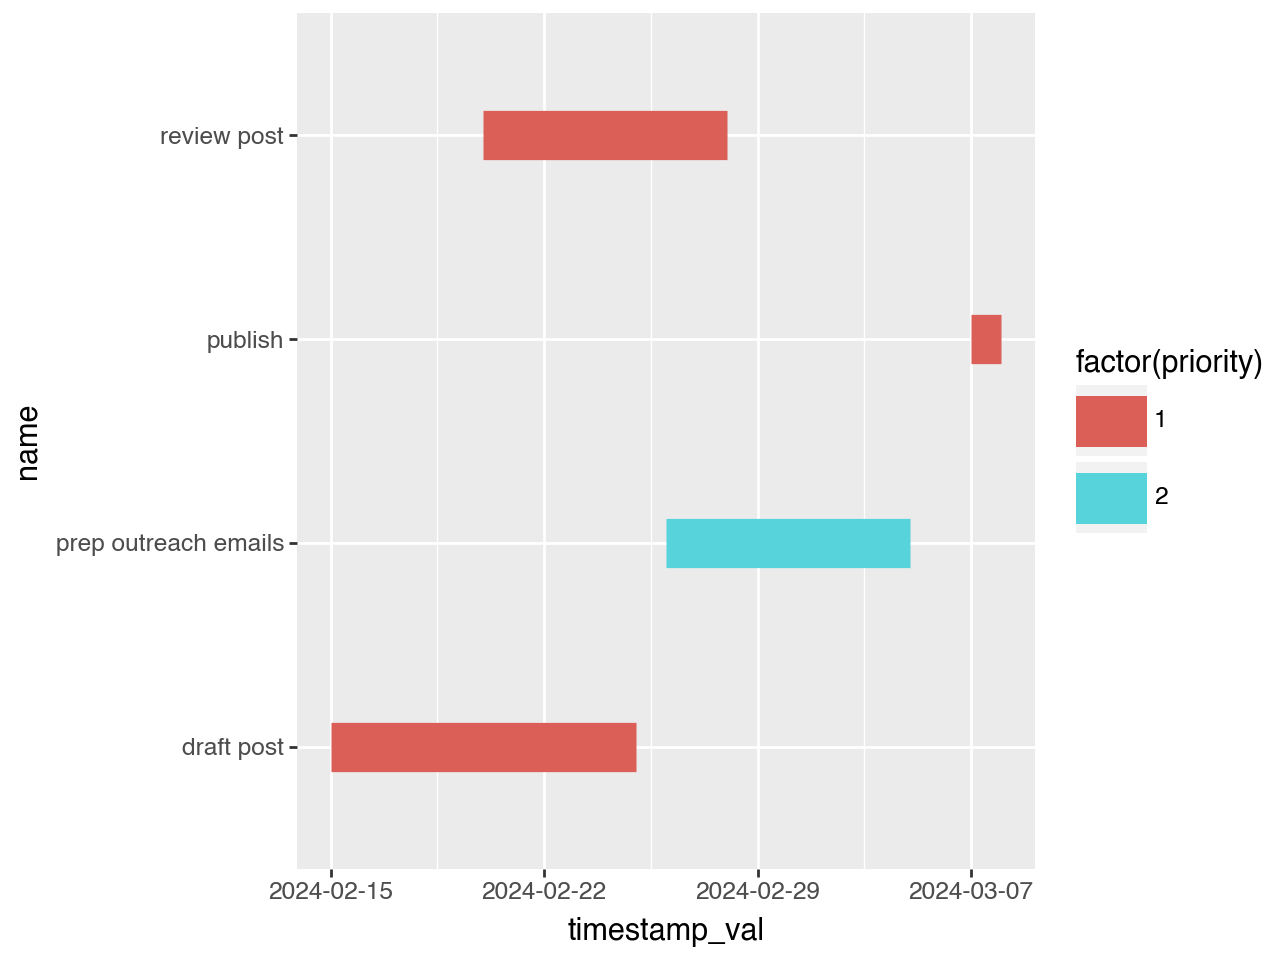

In [4]:
(
    p9.ggplot(gnatt_melted, p9.aes(x='timestamp_val', y='name', group='name', color='factor(priority)'))
    + p9.geom_line(size=10)
    + p9.scale_x_date(breaks='1 week')
)

Problems with this graph:

* Ordering of the y-axis
* y-labels could be moved into the bars
* Can use text labels to replace y text label, and the priority
* Remove the labels on axes as they are not adding value

## Second attempt - Ordering categories

ggplot / plotnine makes arranging categories much harder than it needs to be. The way that I have found that works is to make the names explicitly categorical:

In [5]:
gnatt['label'] = gnatt.apply(lambda row: f"{row["name"]} (P{row.priority})", axis=1)
# Here is the categorical part
gnatt['name'] = pd.Categorical(gnatt['name'], categories=gnatt.sort_values('start')['name'].tolist()[::-1], ordered=True)

gnatt_melted = gnatt.drop('label', axis=1).melt(["name", "priority"], var_name='timestamp_type', value_name='timestamp_val').sort_values('timestamp_val')


Now the same plotting code will line the categories up properly:

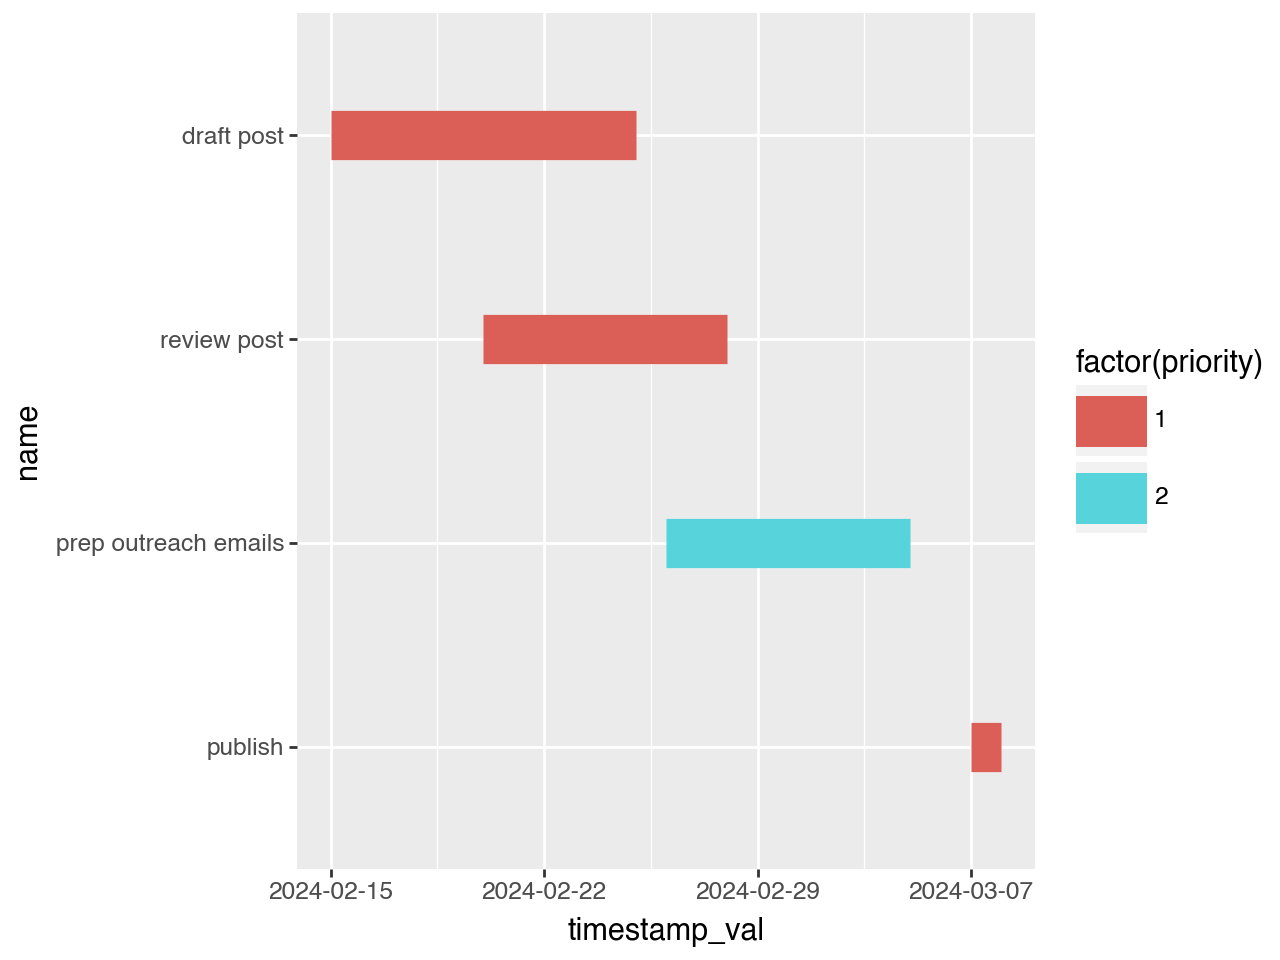

In [6]:
(
    p9.ggplot(gnatt_melted, p9.aes(x='timestamp_val', y='name', group='name', color='factor(priority)'))
    + p9.geom_line(size=10)
    + p9.scale_x_date(breaks='1 week')
)

## Third attempt: Tidying up

Now let's make some of the other improvements!

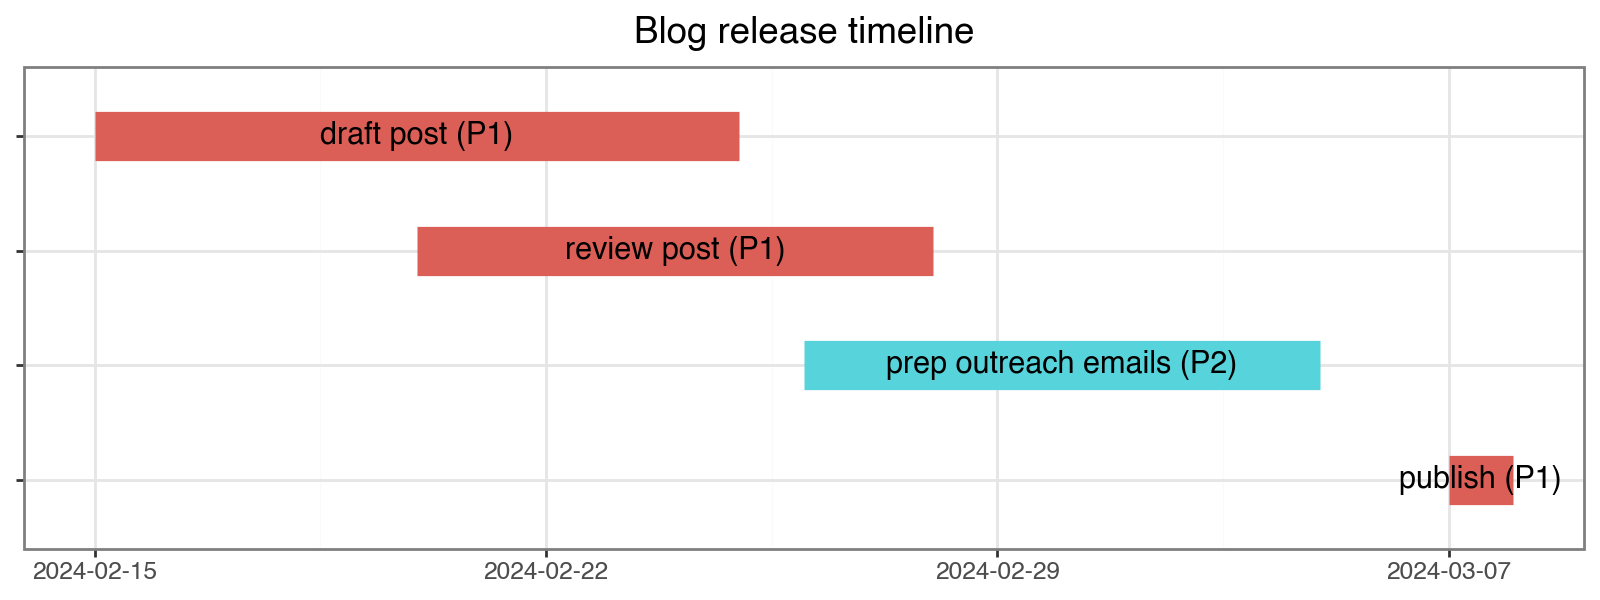

In [9]:
(
    p9.ggplot(gnatt_melted, p9.aes(x='timestamp_val', y='name', group='name', color='factor(priority)'))
    + p9.geom_line(size=10)
    + p9.scale_x_date(breaks='1 week')
    + p9.labs(title='Blog release timeline', x='', y='')
    + p9.geom_text(data=gnatt, mapping=p9.aes(label='label', x='mid', y='name'), color="black")
    + p9.scale_color_discrete(guide=None)
    + p9.scale_y_discrete(labels= lambda v:["" for _ in v]) 
    + p9.theme_bw()
    + p9.theme(figure_size=(8, 3), )
)